In [1]:
import os
import pandas as pd
import numpy as np

import catboost
print(catboost.__version__)

1.2.8


In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41/raw/d42d226d0dd64e7f5395a0eec1b9190a10edbc03/Medical_Cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
y = df['charges']
X = df.drop('charges', axis=1)

In [6]:
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [7]:
cat_features = [1,3,4,5]
print(cat_features)

[1, 3, 4, 5]


In [8]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10)

model.fit(X, y, cat_features=cat_features, verbose=5)

Learning rate set to 0.5
0:	learn: 7787.0489866	total: 226ms	remaining: 2.04s
5:	learn: 4560.8501449	total: 700ms	remaining: 467ms
9:	learn: 4380.1688426	total: 1.21s	remaining: 0us


In [9]:
model.predict(X)

array([19654.86890676,  4327.79540466,  6394.05757217, ...,
        3133.7350406 ,  2861.55162174, 34285.14154651])

### Working with dataset
There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class. Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [10]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_test, 
    label=y_test, 
    cat_features=cat_features
)

In [12]:
model = CatBoostRegressor(
    iterations=5,
    learning_rate=0.1,
    loss_function='RMSE'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'RMSE'}


In [13]:
model = CatBoostRegressor(
    iterations=15,
    verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.5
0:	learn: 7608.2906506	test: 7667.5765651	best: 7667.5765651 (0)	total: 55.9ms	remaining: 783ms
5:	learn: 4604.5635186	test: 4106.7789446	best: 4106.7789446 (5)	total: 457ms	remaining: 686ms
10:	learn: 4429.2010329	test: 4065.7452484	best: 4039.2627286 (8)	total: 770ms	remaining: 280ms
14:	learn: 4259.1387065	test: 4064.9212176	best: 4039.2627286 (8)	total: 1.14s	remaining: 0us

bestTest = 4039.262729
bestIteration = 8

Shrink model to first 9 iterations.


In [14]:
model = CatBoostRegressor(
    iterations=50,
    learning_rate=0.5,
    loss_function='RMSE'
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
model_with_early_stop = CatBoostRegressor(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
# it's not tracking the r2 score, just shows the value of r2 score when the training got stopped

model_with_early_stop = CatBoostRegressor(
    eval_metric='R2',
    iterations=200,
    learning_rate=0.2,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
model = CatBoostRegressor(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50)

0:	learn: 11698.0681489	total: 80.3ms	remaining: 16s
50:	learn: 5562.4329865	total: 3.63s	remaining: 10.6s
100:	learn: 4610.5616517	total: 7.29s	remaining: 7.14s
150:	learn: 4404.2985249	total: 10.2s	remaining: 3.31s
199:	learn: 4289.2492600	total: 13.3s	remaining: 0us


In [18]:
predictions = []
for prediction in model.staged_predict(ntree_end=5, data=X_test):
    predictions.append(prediction)


In [19]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['R2'],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
print('R2 score:\n{}'.format(np.array(metrics['R2'])))

R2 score:
[0.0476055  0.09419045 0.13704105 0.17107418 0.20627582 0.233224
 0.26805049 0.29887582 0.32762497 0.35691078 0.38184743 0.40846397
 0.42678117 0.45101735 0.470458   0.48810145 0.50700867 0.5247933
 0.54455093 0.56189701 0.57897667 0.59015672 0.60657234 0.62153603
 0.63517158 0.64923001 0.66258151 0.67504709 0.68702123 0.69824218
 0.70507549 0.7139939  0.72414011 0.73264667 0.74030284 0.74863311
 0.75491661 0.76139972 0.76834235 0.77522373 0.78041802 0.78591667
 0.79164642 0.79729469 0.80240781 0.80705852 0.81100184 0.81559341
 0.81963746 0.82371742 0.82593967 0.82927444 0.83291623 0.83641682
 0.83927108 0.84235281 0.84496723 0.84755655 0.85033869 0.8527761
 0.85445654 0.85634335 0.858658   0.86058071 0.86239015 0.86380236
 0.86473702 0.86619038 0.86756072 0.86905834 0.87093029 0.87247498
 0.87353561 0.87497055 0.87617089 0.87741797 0.87866891 0.87984704
 0.88071964 0.88177728 0.88288225 0.88367337 0.88433998 0.88499502
 0.88585792 0.8865104  0.88707518 0.88775974 0.88804194 

# Feature importances
Prediction values change
Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes. These feature importances are non negative. They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [22]:
np.array(model.get_feature_importance(prettified=True))

array([['smoker', 76.31805508436925],
       ['bmi', 12.693505668368188],
       ['age', 8.603279276464882],
       ['children', 1.363812132906847],
       ['region', 0.8408094101656046],
       ['sex', 0.1805384277252453]], dtype=object)

<Axes: title={'center': 'Feature Importance'}>

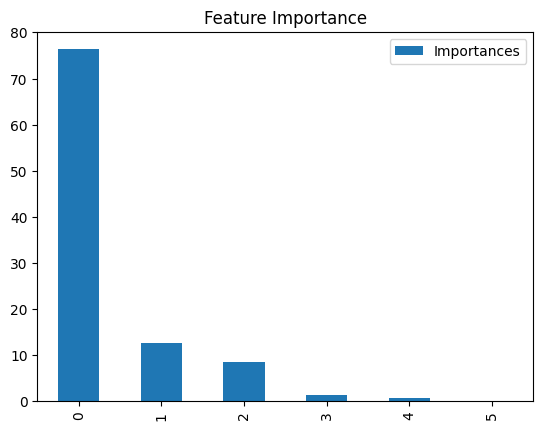

In [23]:
# Plot feature importances
model.get_feature_importance(prettified=True).plot(kind='bar', title='Feature Importance')

# Loss function change
The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes. This importances might be negative if the feature has bad influence on the loss function. The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value. To calculate this importance value you need to pass train_pool as an argument.

In [24]:
np.array(model.get_feature_importance(
    train_pool, 
    type='LossFunctionChange', 
    prettified=True
))

array([['smoker', 6262.829741268003],
       ['age', 1292.5628566317873],
       ['bmi', 959.5073119629296],
       ['children', 87.2395469076614],
       ['region', 22.088282256054754],
       ['sex', 5.413669543065225]], dtype=object)

In [25]:
# Compute the interaction strengths
interaction_strengths = model.get_feature_importance(
    train_pool,
    type='Interaction',
)

interaction_strengths

array([[0.        , 3.        , 8.89546955],
       [0.        , 5.        , 8.353932  ],
       [2.        , 5.        , 8.07461239],
       [0.        , 2.        , 7.67368015],
       [2.        , 3.        , 6.82609129],
       [3.        , 5.        , 6.73720189]])